Forked as Gist from GitHub user [jaimergp](https://gist.github.com/jaimergp/84a1aa90d8fb67cbb74172af537c7c0f).

Following the recommendations described in 

Grossfield A., Zuckerman D. Quantifying uncertainty and sampling quality in biomolecular simulations. Annu Rep Comput Chem . 2009 January 1; 5: 23–48

some qualitative studies of the MD convergence are performed in this notebook. 

Concretely:

1. RMSD from the first frame
2. All to all frames RMSD analysis
3. Principal Component Analysis
4. Clustering analysis

In [4]:
%matplotlib inline
import mdtraj as md
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import time

In [5]:
# Trajectory file name (.dcd) and topology file name (.prmtop)
#(Free porcine)
trajectory_filename = '/media/jsanchez/TOSHIBA/oxaliplatin_insulin/Insuline_Revision/Ins_free_porcine/Porcine/13659/traj_500ns.dcd'
topology_filename = '/media/jsanchez/TOSHIBA/oxaliplatin_insulin/Insuline_Revision/Ins_free_porcine/Porcine/13659/noW.Insuline_solv.prmtop'

Load the trajectory

In [6]:
trajectory = md.load(trajectory_filename, top=topology_filename)
traj_length = 500 #Length of the trajectory in ns (for a correct axis labels in plots)
print(trajectory)

<mdtraj.Trajectory with 24934 frames, 784 atoms, 53 residues, and unitcells>


Select the atoms that will be object of study (for example, alpha-C of the backbone) (http://mdtraj.org/1.6.2/examples/atom-selection.html)

In [8]:
#(Free) selection = trajectory.topology.select("(name CA and resid 0 to 6) or (name CA and resid 12 to 20) or (name CA and resid 25 to 39)")
#(Free porcine) 
selection = trajectory.topology.select("(name CA and resid 0 to 6) or (name CA and resid 12 to 20) or (name CA and resid 25 to 38)")
#(CYX) selection = trajectory.topology.select("((element=~'[NCP]') and (resid 51 to 52)) or (name CA and resid 0 to 6) or (name CA and resid 12 to 20) or (name CA and resid 25 to 38)")
#(CysHis) selection = trajectory.topology.select("((element=~'[NCP]') and (resid 51 to 52)) or (name CA and resid 0 to 6) or (name CA and resid 12 to 20) or (name CA and resid 25 to 38)")
#(HIS_OK) selection = trajectory.topology.select("(name CA and resid 0 to 42) or ((element=~'[NCP]') and (resid 51 to 52))")
print(selection)

[  4  11  30  46  61  78  88 163 182 203 220 239 254 268 289 299 383 400
 419 429 436 447 464 483 499 514 524 543 564 583]


## 1. RMSD from the first frame

In [9]:
# Step size: trajectory frames that will be used in the analysis (e.g. if step is 20, frames 0, 20, 40 ... will be selected)
step_RMSD = 25

Calculate RMSD data

In [10]:
distances = md.rmsd(trajectory, trajectory, frame = 0, atom_indices = selection)*10 #distances in Angstroms

Plot the data

In [11]:
#Output filename for the plot
RMSD_filename = '/home/jsanchez/RMSD.pdf'

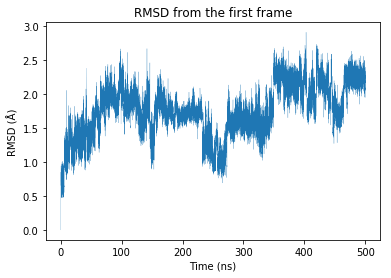

In [12]:
plt.figure()
plt.plot([traj_length*a/len(distances) for a in range(len(distances))], distances, linewidth=0.2)
plt.xlabel('Time (ns)')
plt.ylabel('RMSD (Å)')
plt.title('RMSD from the first frame')
plt.savefig(RMSD_filename, bbox_inches='tight')

## 2. All to All RMSDs

In [13]:
# Step size: trajectory frames that will be used in the analysis (e.g. if step is 20, frames 0, 20, 40 ... will be selected)
step_all = step_RMSD

In [14]:
traj_all = trajectory[::step_all]
traj_all = traj_all.atom_slice(selection)

In [15]:
# Calculate all-to-all RMSD matrix (it could take some time if you choose a small step size!)
distances = np.empty((math.ceil(traj_all.n_frames), math.ceil(traj_all.n_frames)))
for i, frame in enumerate(range(0, traj_all.n_frames)):
    distances[i] = md.rmsd(traj_all, traj_all, frame = i)*10 #distances in Angstroms

Plot the data

In [30]:
traj_all

<mdtraj.Trajectory with 998 frames, 30 atoms, 30 residues, and unitcells at 0x7f1077d6da20>

In [16]:
#Output filename for the plot
all_filename = '/home/jsanchez/All_RMSD.pdf'

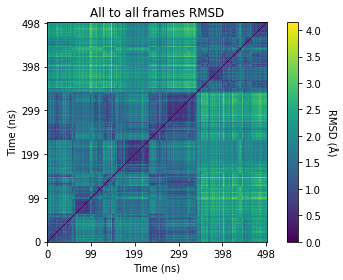

In [37]:
fig, ax = plt.subplots()
im = ax.imshow(distances, origin='lower')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label('RMSD (Å)', rotation=-90, va="bottom")
ticks = np.arange(0, len(distances), len(distances)//5)
plt.xticks(ticks, [int(a*traj_length/len(distances)) for a in ticks])
plt.yticks(ticks, [int(a*traj_length/len(distances)) for a in ticks])
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Time (ns)')
ax.set_title('All to all frames RMSD')
fig.tight_layout()
plt.savefig(all_filename, bbox_inches='tight')
plt.show()

## 3. PCA analysis 
(based on http://mdtraj.org/1.9.0/examples/pca.html)

Create a two component PCA model, and project our data down into this reduced dimensional space. Using just the cartesian coordinates as input to PCA, it's important to start with some kind of alignment.

In [38]:
# Step size: trajectory frames that will be used in the analysis (e.g. if step is 20, frames 0, 20, 40 ... will be selected)
step_PCA = 25

In [39]:
traj_PCA = trajectory[::step_PCA]
traj_PCA = traj_PCA.atom_slice(selection)
pca1 = PCA(n_components=2)
traj_PCA.superpose(traj_PCA, 0)

<mdtraj.Trajectory with 998 frames, 30 atoms, 30 residues, and unitcells at 0x7f1077bb63c8>

In [40]:
reduced_cartesian = pca1.fit_transform(traj_PCA.xyz.reshape(traj_PCA.n_frames, traj_PCA.n_atoms * 3))
print(reduced_cartesian.shape)

(998, 2)


Plotting the data

In [41]:
# Output filename for PCA plot (.pdf)
PCA_filename = '/home/jsanchez/PCA_free_porcine.pdf'

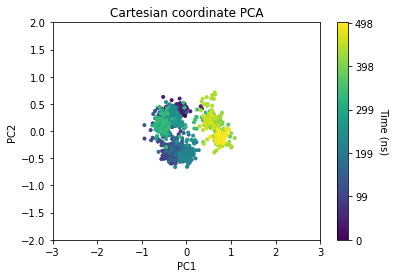

In [48]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='.', c=range(len(traj_PCA)))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim([-3.0, 3.0])
plt.ylim([-2.0, 2.0])
plt.title('Cartesian coordinate PCA')
cbar = plt.colorbar()
ticks = np.arange(0, len(traj_PCA), len(traj_PCA)//5)
cbar.set_ticks(ticks)
cbar.set_ticklabels([int(a*traj_length/len(traj_PCA)) for a in ticks])
cbar.set_label('Time (ns)', rotation=-90, va="bottom")
plt.savefig(PCA_filename, bbox_inches='tight')

## 4. Cluster analysis as described in:

Daura X, van Gunsteren WF, Mark AE. Folding-unfolding thermo-dynamics of a-heptapeptide from equilibrium simulations. Proteins Struct Funct Genet 1999;34:269–280

Smith LJ, Daura X, van Gunsteren WF. Assessing equilibration and convergence in biomolecular simulations. Proteins Struct Funct Genet 2002;48:487-496

In [49]:
# Step size: trajectory frames that will be used in the analysis (e.g. if step is 20, frames 0, 20, 40 ... will be selected)
step_cluster = 10

In [50]:
traj_cluster = trajectory[::step_cluster]
traj_cluster = traj_cluster.atom_slice(selection)

Calculate distances AllToAll frames (it could take some time in function of the number of frames)

In [51]:
#Calculate distances AllToAll frames (it could take some time in function of the number of frames)
distances = np.zeros((traj_cluster.n_frames, traj_cluster.n_frames))

#counter stuff
num_iter = traj_cluster.n_frames
num_updates = 20
update_per = num_iter // num_updates  # make sure it's an integer
print('|{}|'.format(' ' * (num_updates - 2)))  # gives you a reference

t0 = time.time()
for i, frame in enumerate(range(0, traj_cluster.n_frames)):
    distances[i] = md.rmsd(traj_cluster, traj_cluster, frame = i) * 10 # Distances in Angstroms
    #counter stuff
    if i % update_per == 0:
        print('*', end='', flush=True)
print(time.time()-t0)


|                  |
*********************0.8503129482269287


In [52]:
# Distance of cutoff of clusters (in Angstroms)
dc = 2.0
# Number of frames of distance between each calculation of #clusters
step_cl = 50

Calculate clusters

In [55]:
n_clusters = {}
frame = 0

#counter stuff
num_iter = traj_cluster.n_frames
num_updates = int(traj_cluster.n_frames/step_cl)
update_per = num_iter // num_updates  # make sure it's an integer
print('|{}|'.format(' ' * (num_updates - 2)))  # gives you a reference

while (frame + step_cl) < traj_cluster.n_frames:
    frame += step_cl
    survivors = [i for i in range(0, frame)]
    n_clusters[frame] = 0
    while(survivors):
        rows = columns = np.array(survivors, dtype=np.intp)
        surv_dist = distances[rows[:, np.newaxis], columns] #Catch the submatrix of distances of the survivor frames
        neighbours = np.zeros(len(survivors))
        for i in range(0, len(survivors)):
            neighbours[i] = len(np.where(surv_dist[i] < dc)[0])
        cluster_center = np.argmax(neighbours, axis=0)
        to_remove = [survivors[a] for a in np.where(surv_dist[cluster_center] < dc)[0]]
        for elem in to_remove:
            survivors.remove(elem)
        n_clusters[frame] += 1
    #counter stuff
    if frame % update_per == 0:
        print('*', end='', flush=True)

|                                               |
*************************************************

In [59]:
n_clusters

{50: 1,
 100: 1,
 150: 1,
 200: 1,
 250: 1,
 300: 1,
 350: 1,
 400: 1,
 450: 2,
 500: 2,
 550: 2,
 600: 2,
 650: 2,
 700: 2,
 750: 3,
 800: 3,
 850: 3,
 900: 3,
 950: 3,
 1000: 3,
 1050: 3,
 1100: 3,
 1150: 3,
 1200: 3,
 1250: 3,
 1300: 3,
 1350: 3,
 1400: 3,
 1450: 3,
 1500: 3,
 1550: 3,
 1600: 3,
 1650: 3,
 1700: 3,
 1750: 4,
 1800: 4,
 1850: 5,
 1900: 4,
 1950: 4,
 2000: 4,
 2050: 4,
 2100: 4,
 2150: 4,
 2200: 4,
 2250: 4,
 2300: 4,
 2350: 4,
 2400: 5,
 2450: 5}

Plot the data

In [56]:
cluster_filename = '/home/jsanchez/cluster_2_0.pdf'

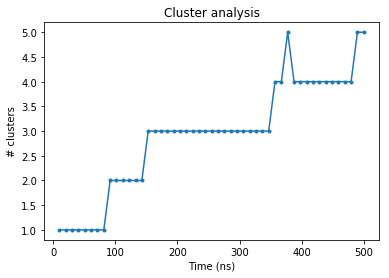

In [58]:
plt.figure()
plt.plot([a*traj_length/max(n_clusters.keys()) for a in n_clusters.keys()], n_clusters.values(), marker='.')
plt.xlabel('Time (ns)')
plt.ylabel('# clusters')
plt.title('Cluster analysis')
plt.savefig(cluster_filename, bbox_inches='tight')